# 3_view_thalamus_gene_expression

This notebook demonstrates how to use the custom plotting functions found in the
`thalamus_merfish_analysis\ccf_plots.py` module to view spatial gene expression 
measured by MERFISH in the thalamus and zona incerta.

Part 1: View Thalamus-wide Gene Expression

Part 2: Find & View DEGs (Differentialy Expressed Genes) 

Part 3: View HCR / Multi-GEne Experiment Simulation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import anndata as ad
import pandas as pd
import numpy as np

import scanpy as sc

from thalamus_merfish_analysis import abc_load as abc
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import ccf_plots as cplots

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# import warnings

# # suppress FutureWarning warnings (targeting AnnData & Seaborn)
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings("ignore", message=".*Trying to modify attribute `.obs` of view, initializing view as actual.*")

## Set figure generation & saving behavior

In [4]:
# This notebook takes awhile to run if you're displaying & saving out all the 
# DEGs found herein, so to speed things along, set these variables to control
# global figure displaying & saving behavior

# whether to save figures to /results
save_figs = False # suggested to minimize runtime: False

# number of DEGs to plot 
n_de_genes_to_plot = 2 # suggested to minimize runtime: 2

## Load thalamus dataset

Since we want to view gene expression, we need to load the full AnnData object.

For details on the AnnData output of `load_standard_thalamus()`, please see `1_load_thalamus_data.ipynb`.

In [5]:
# load AnnData object so we have the gene expression
# standard behavior loads in log2cpm gene counts, which are suitable for both
# DEG analysis and gene expression display
adata_th_log2cpm = abc.load_standard_thalamus(data_structure='adata')
adata = adata_th_log2cpm

### set spatial coordinates

Since we have 3 sets of spatial coordinates (`_section`, `_reconstructed`, and `_ccf`), we need to specify which coordinate space we wish to work from.

For this notebook, we will work in the `_reconstructed` coordinate space, which is a registration of each MERFISH section to a target resampled CCF section. 
For more information on the different coordinates, please see: https://alleninstitute.github.io/abc_atlas_access/notebooks/merfish_ccf_registration_tutorial.html

In [6]:
# set spatial column names to `_reconstructed` coordinate space
coords = '_reconstructed'

x_col = 'x'+coords
y_col = 'y'+coords
section_col = z_col = 'z'+coords

### load Allen Reference Atlas (ARA) structure images & boundaries

To overlay the ARA structures on the cell types found in the thalamus, we need to load the volume & boundary images from the ABC Atlas, which are referred to as 'CCF' from here on out.

In [7]:
# Load the CCF structures image
ccf_images = abc.get_ccf_labels_image()

In [8]:
# specify CCF parcellation level column in adata.obs
ccf_label = 'parcellation_substructure'

In [9]:
# Precompute boundaries to use multiple times in this notebook w/o need to recompute

# we only need to load the boundaries for sections that contain the thalamus
sections_all = sorted(adata.obs[section_col].unique())
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)

# precompute boundaries for thalamic sections
ccf_boundaries = cimg.sectionwise_label_erosion(ccf_images, distance_px=1, 
                                                fill_val=0, return_edges=True, 
                                                section_list=sections_int
                                                )

# # Alternative: skip and define as None to calculate on the fly
# ccf_boundaries = None

### load custom cluster color palette

In [10]:
# Load custom, contrast-y cluster color palette
palette_df = pd.read_csv('/code/resources/cluster_palette_glasbey.csv')
cluster_palette = dict(zip(palette_df['Unnamed: 0'], palette_df['0']))

## 1.) View Thalamus-wide Gene Expression

We provide 3 main ways to view thalamus-wide gene expression

1a) Gene expression only

1b) Gene expression + CCF parcellation boundaries overlay

1c) Gene expression + highlight specific CCF parcellation boundar(y/ies)

In [11]:
# 3 sections that representatively span the AP axis of the thalamus
sections_3 = [6.4, 7.2, 8.0]

### 1a) Gene expr only

The `plot_expression_ccf()` function in the `ccf_plots` module displays per-section gene expression of a specified gene.

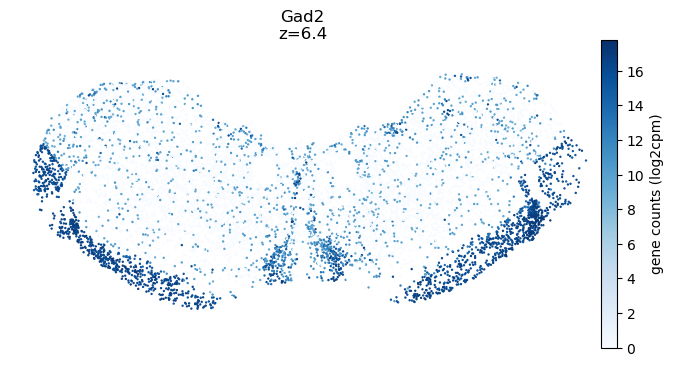

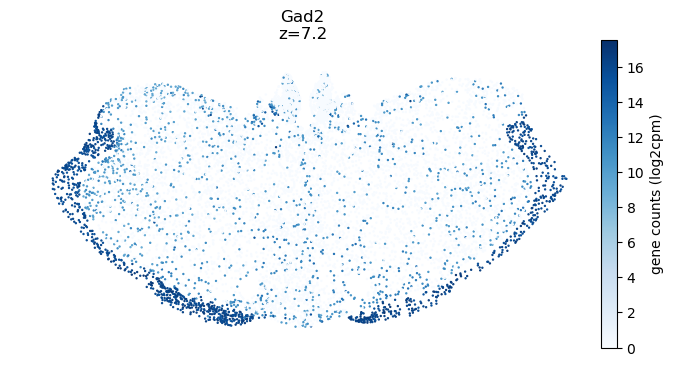

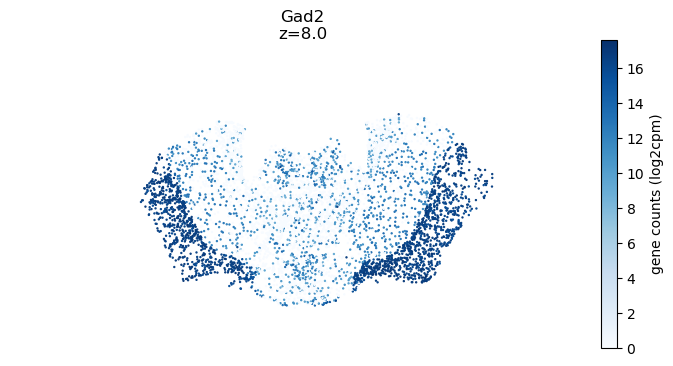

In [12]:
figs = cplots.plot_expression_ccf(adata, # loaded AnnData obj
                                  'Gad2', # the 1 gene to display
                                  ccf_images, # preloaded CCF image volumes
                                  boundary_img=ccf_boundaries, # precalculated for speed
                                  nuclei=[], # does NOT show CCF parcellations
                                  sections=sections_3, # set to None to plot all available sections
                                                       # to plot single section, wrap in list: e.g. sections=[6.4] 
                                  cmap='Blues', # accepts any matplotlib colormap 
                                  section_col=section_col, x_col=x_col, y_col=y_col # defined in prior cell
                                  )

### 1b) Gene expr + CCF parcellation overlay

By setting `nuclei=None`, the function will plot all CCF parcellation boundaries over the gene's expression

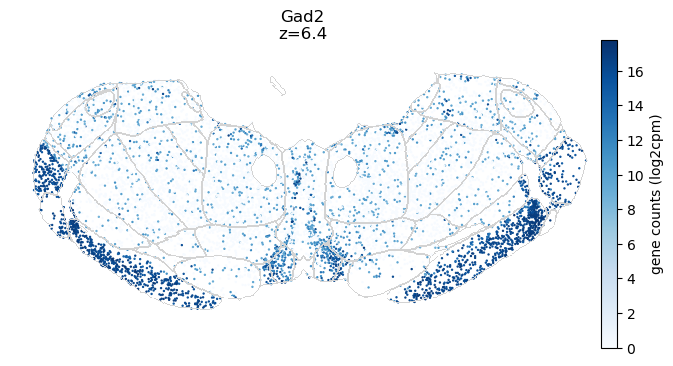

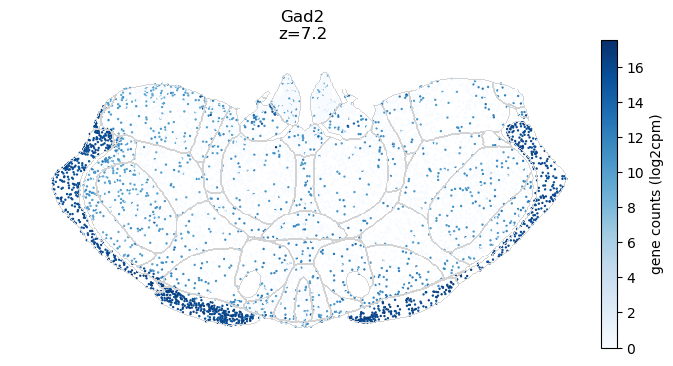

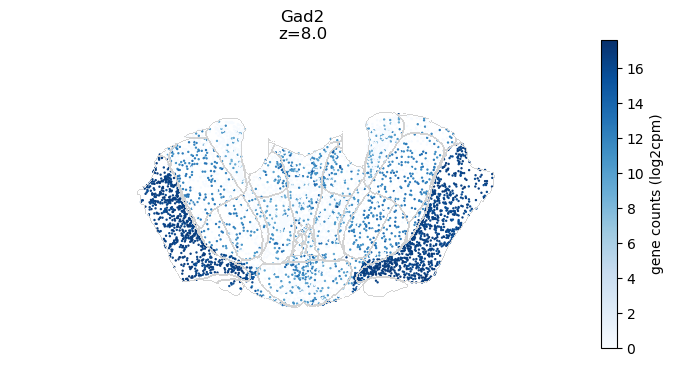

In [13]:
# By setting `nuclei=None` (the default value), the function will plot all CCF parcellation
# boundaries over the gene's expression
figs = cplots.plot_expression_ccf(adata,
                                  'Gad2',
                                  ccf_images,
                                  boundary_img=ccf_boundaries,
                                  nuclei=None, # default, plots all available CCF parcellation structures
                                  sections=sections_3,
                                  cmap='Blues',
                                  section_col=section_col, x_col=x_col, y_col=y_col
                                  )

### 1c) Gene expr + highlight specific CCF structures

By passing a list of CCF substructures to `highlight=['PF', 'AD']`, the 
`plot_expression_ccf()` function will show all CCF parcellation boundaries with 
grey outline and highlight the `highlight` substructures with a black outline

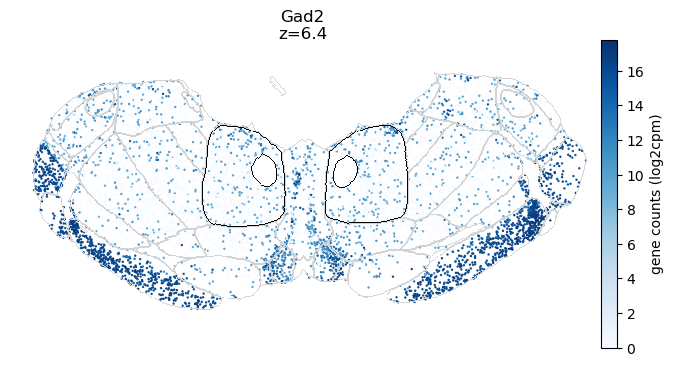

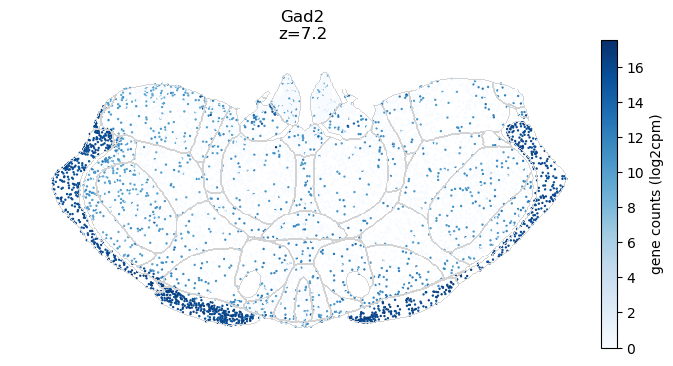

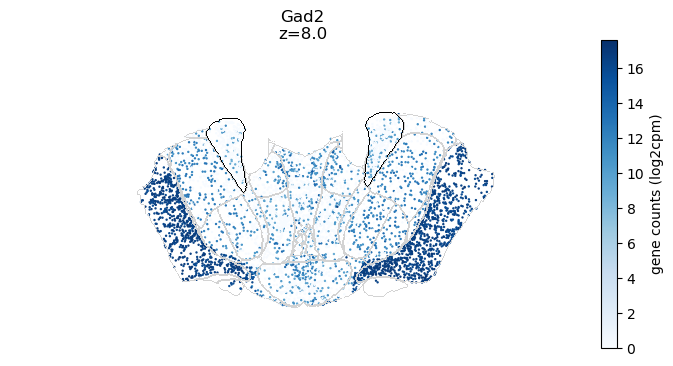

In [15]:
# Pass a list of substrucutres to `highlight` to highlight them with a black outline
figs = cplots.plot_expression_ccf(adata,
                                  'Gad2',
                                  ccf_images,
                                  boundary_img=ccf_boundaries,

                                  nuclei=None, # default, plots all CCF substructures with grey outline
                                               # set nuclei=[] to plot no background/grey CCF substructures

                                  highlight=['PF', 'AD'], # highlights certain parcellations with black outline
                                                          # to plot one substructure, wrap in list: e.g. highlight=['AV']
                                                          
                                  sections=sections_3,
                                  section_col=section_col, x_col=x_col, y_col=y_col)

## Find & View DEGs

We performed differential expression analysis with scanpy’s `rank_genes_group` 
function   to identify differentially expressed genes (DEGs) between spatially 
adjacent cell types in the thalamus. 

#### run_sc_deg_analysis()

A helper function to run DEG analysis and format the output

In [32]:
def run_sc_deg_analysis(adata, taxonomy_level, groups='all', reference='rest',
                        n_genes_display=20, rankby_abs=True, method='wilcoxon',
                        save_to_key=None, print_as_lists=True):
            
    # rank genes
    sc.tl.rank_genes_groups(adata, taxonomy_level, groups=groups, 
                            reference=reference, n_genes=None, rankby_abs=True,
                            method=method, key_added=save_to_key)
    
    # change default key if input parameter was set
    if save_to_key==None:
        key='rank_genes_groups'
    else:
        key=save_to_key
    
    # plot top n_genes_display
    sc.pl.rank_genes_groups(adata, n_genes=n_genes_display, key=key)
    
    # print out lists of top DEGs so they can be copy-pasted elsewhere
    if print_as_lists:
        n_genes_print = int(np.floor(n_genes_display/2))

        deg_df = sc.get.rank_genes_groups_df(adata, group=None, key=key)

        degs_top_all = deg_df.head(n_genes_display).names.to_list()
        degs_top_pos = deg_df[deg_df['scores']>0].head(n_genes_print).names.to_list()
        degs_top_neg = deg_df[deg_df['scores']<0].head(n_genes_print).names.to_list()

        print(f'\nTop {n_genes_display} DEGs for {groups} vs {reference}:\n', 
              degs_top_all)
        print(f'\nTop {n_genes_print} positive DEGs for {groups} vs {reference}:\n', 
              degs_top_pos)
        print(f'\nTop {n_genes_print} negative DEGs for {groups} vs {reference}:\n', 
              degs_top_neg)
        
    return degs_top_all, degs_top_pos, degs_top_neg

#### set default plotting kwargs

In [ ]:
kwargs_expr = dict(
    bg_cells=obs_th_strict,
    section_col=section_col,
    x_col = 'x_'+coords,
    y_col = 'y_'+coords,
    s=4, 
    shape_palette='dark_outline',
    boundary_img=ccf_boundaries
)

### Anterior Thalamic Nuclei (ATN) DEGs

We will use the anterior thalamic nuclei (ATN) as an example of using DEG analysis
to explore and compare the cell types found in the thalamus.

#### Get ATN cell types from resource CSV file

We generated a CSV file that maps each thalamic nucleus to a manually selected 
set of top clusters (lowest cell type level of the taxonomy) that map to cells 
within that nucleus’ boundaries.

In [ ]:
# load manual cluster annotations for thalamic nuclei
nuclei_cluster_df = pd.read_csv("resources/prong1_cluster_annotations_by_nucleus.csv", 
                                index_col=0)
nuclei_cluster_df

In [15]:
# Extract Prong 1 cluster-nucleus groups
taxonomy_level = 'cluster'

AD_cluster_aliases = nuclei_df.loc['AD',:].cluster_alias.split(', ')
AD_cluster_labels = abc.get_taxonomy_label_from_alias(AD_cluster_aliases,
                                                      taxonomy_level, 
                                                      version='20230830')

AV_cluster_aliases = nuclei_df.loc['AV',:].cluster_alias.split(', ')
AV_cluster_labels = abc.get_taxonomy_label_from_alias(AV_cluster_aliases,
                                                      taxonomy_level, 
                                                      version='20230830')

AM_cluster_aliases = nuclei_df.loc['AM',:].cluster_alias.split(', ')
AM_cluster_labels = abc.get_taxonomy_label_from_alias(AM_cluster_aliases,
                                                      taxonomy_level, 
                                                      version='20230830')

ANT_cluster_labels = AD_cluster_labels+AV_cluster_labels+AM_cluster_labels
print(ANT_cluster_labels)

['2613 AD Serpinb7 Glut_1', '2614 AD Serpinb7 Glut_1', '2615 AV Col27a1 Glut_1', '2616 AV Col27a1 Glut_1', '2674 TH Prkcd Grin2c Glut_9', '2675 TH Prkcd Grin2c Glut_9', '2676 TH Prkcd Grin2c Glut_9']


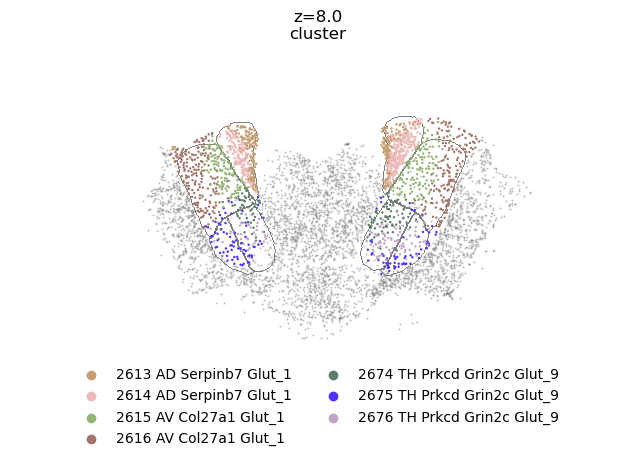

In [16]:
anterior_sec = 8.0
nuclei = ['AD', 'AV', 'AMd', 'AMv']

obs_ANT = adata_th_zi_neurons.obs[adata_th_zi_neurons.obs['cluster'].isin(ANT_cluster_labels)]

ant_fig = cplots.plot_ccf_overlay(obs_ANT, ccf_polygons, bg_cells=obs_th_neurons, 
                                  point_hue='cluster', sections=[anterior_sec],
                                  shape_palette='dark_outline', s=3, 
                                  point_palette=cluster_palette,
                                  ccf_names=nuclei, legend='cells', bg_shapes=False, 
                                  section_col=section_col, 
                                  x_col=x_col, y_col=y_col)
if save_figs:
    ant_fig.savefig(f'../results/abc_deg_AD_cluster{cluster_id}_{gene}.pdf', 
                    transparent=True, bbox_inches='tight')

### AD - subclass vs rest

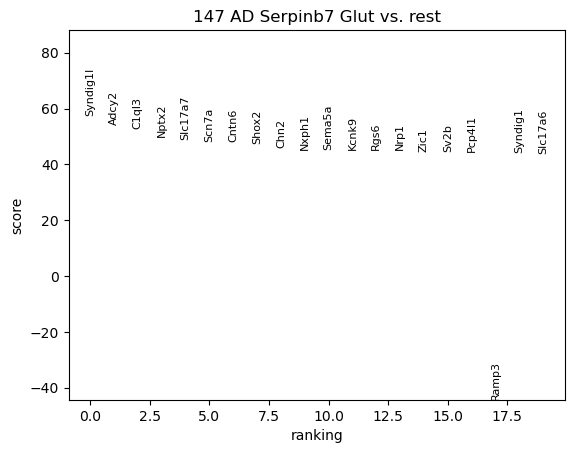


Top 20 DEGs for ['147 AD Serpinb7 Glut'] vs rest:
 ['Syndig1l', 'Adcy2', 'C1ql3', 'Nptx2', 'Slc17a7', 'Scn7a', 'Cntn6', 'Shox2', 'Chn2', 'Nxph1', 'Sema5a', 'Kcnk9', 'Rgs6', 'Nrp1', 'Zic1', 'Sv2b', 'Pcp4l1', 'Ramp3', 'Syndig1', 'Slc17a6']

Top 10 positive DEGs for ['147 AD Serpinb7 Glut'] vs rest:
 ['Syndig1l', 'Adcy2', 'C1ql3', 'Nptx2', 'Slc17a7', 'Scn7a', 'Cntn6', 'Shox2', 'Chn2', 'Nxph1']

Top 10 negative DEGs for ['147 AD Serpinb7 Glut'] vs rest:
 ['Ramp3', 'Calb1', 'Spon1', 'Nr2f1', 'Epha4', 'Grik1', 'Tmem132c', 'Galnt18', 'Tnnt1', 'Tafa4']


In [33]:
# AD subclass - '147 AD Serpinb7 Glut'
taxonomy_level = 'subclass'
key = 'AD_subclass_vs_rest'

(degs_top_all, 
degs_top_pos, 
degs_top_neg) = run_sc_deg_analysis(adata_th_zi_neurons, taxonomy_level, 
                                    groups=['147 AD Serpinb7 Glut'], 
                                    reference='rest',
                                    save_to_key=key)

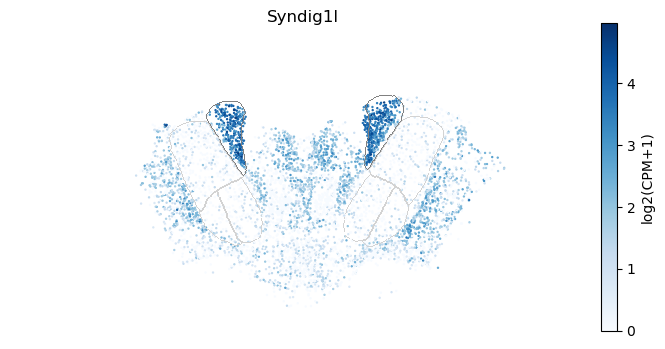

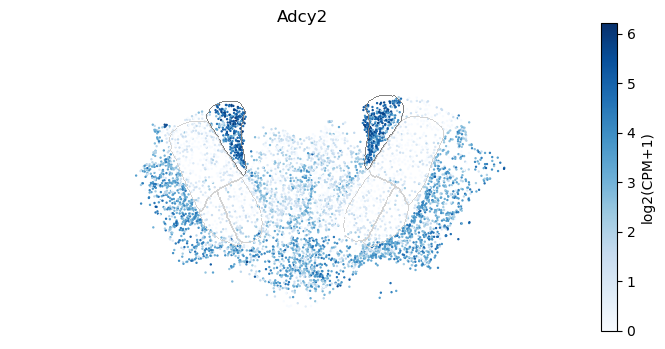

In [35]:
ant_section=[8.0]
ant_nuclei=['AD', 'AV', 'AMd', 'AMv']
highlight_nuclei=['AD']

for gene in degs_top_pos[:n_de_genes_to_plot]:
    cplots.plot_expression_ccf(adata_th_zi_neurons, gene, ccf_polygons,
                               sections=ant_section, nuclei=ant_nuclei, 
                               highlight=highlight_nuclei,
                               section_col=section_col, 
                               x_col=x_col, y_col=y_col);

### AD - 2613 vs 2614 clusters

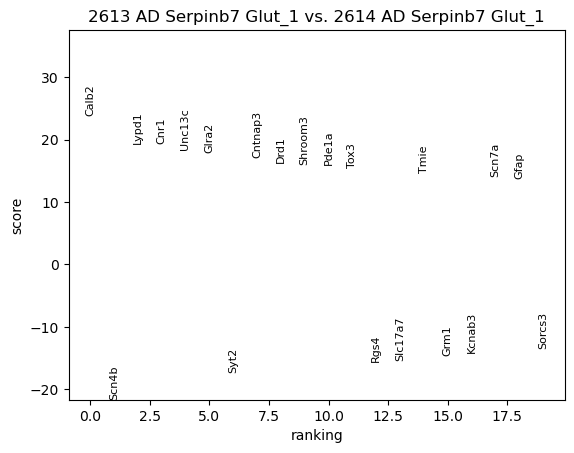

Top 10 DE genes:
 ['Calb2', 'Scn4b', 'Lypd1', 'Cnr1', 'Unc13c', 'Glra2', 'Syt2', 'Cntnap3', 'Drd1', 'Shroom3']

Top 10 pos DE genes:
 ['Calb2', 'Lypd1', 'Cnr1', 'Unc13c', 'Glra2', 'Cntnap3', 'Drd1', 'Shroom3', 'Pde1a', 'Tox3']

 Top 10 neg DE genes:
 ['Scn4b', 'Syt2', 'Rgs4', 'Slc17a7', 'Grm1', 'Kcnab3', 'Sorcs3', 'Rorb', 'Adra1b', 'Kctd8']


In [14]:
taxonomy_level = 'cluster'
AD_cluster_labels = ['2613 AD Serpinb7 Glut_1', '2614 AD Serpinb7 Glut_1']

sc.tl.rank_genes_groups(adata_th_zi_neurons, taxonomy_level, 
                        groups=[AD_cluster_labels[0]], 
                        reference=AD_cluster_labels[1], 
                        method='wilcoxon', rankby_abs=True)
sc.pl.rank_genes_groups(adata_th_zi_neurons, n_genes=20)

de_df = sc.get.rank_genes_groups_df(adata_th_zi_neurons, group=None)
de_genes_AD_clust_all = de_df.head(10).names.to_list()
de_genes_AD_clust_pos = de_df[de_df['scores']>0].head(10).names.to_list()
de_genes_AD_clust_neg = de_df[de_df['scores']<0].head(10).names.to_list()
print('Top 10 DE genes:\n', de_genes_AD_clust_all)
print('\nTop 10 pos DE genes:\n', de_genes_AD_clust_pos)
print('\n','Top 10 neg DE genes:\n', de_genes_AD_clust_neg)

#### 2613 (medial) DE genes

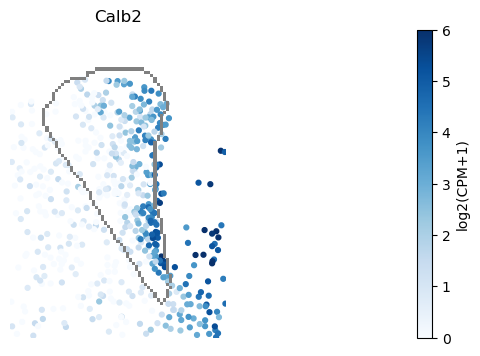

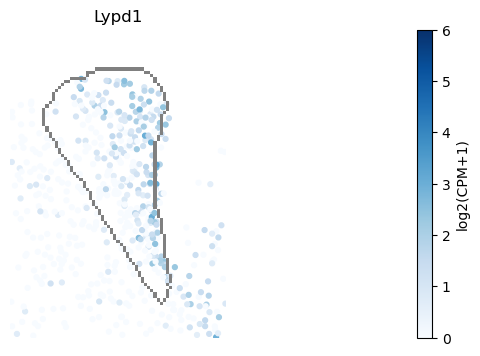

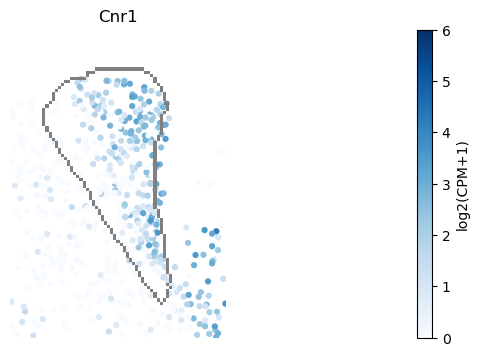

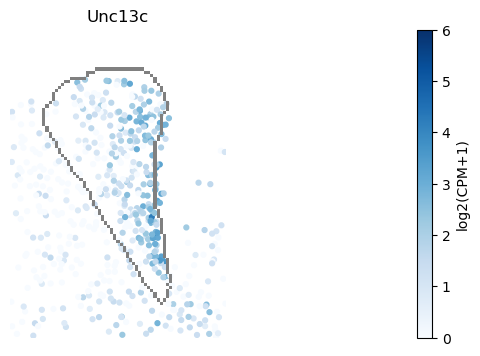

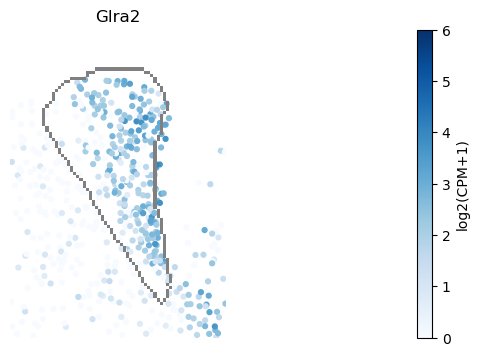

In [15]:
section=[8.0]
ant_nuclei=['AD', 'AV', 'AMd', 'AMv']
highlight_nuclei=['AD']

section_col = 'z_reconstructed'
x_col = 'x_reconstructed'
y_col = 'y_reconstructed'

kwargs = dict(
              s=12
             )
cluster_id = '2613'
for gene in de_genes_AD_clust_pos[:5]:
    curr_fig = cplots.plot_expression_ccf(adata_th_zi_neurons, gene, ccf_polygons,
                                          sections=section, nuclei=highlight_nuclei, 
                                          highlight=highlight_nuclei,
                                           cmap='Blues', bg_shapes=False, show_outline=False,
                                           section_col=section_col, 
                                           x_col=x_col, y_col=y_col,
                                           custom_xy_lims=[4.4,5.1, 5.6,4.6],
                                           cb_vmin_vmax=[0,6], **kwargs)
    curr_fig[0].savefig('/root/capsule/results/'+f'abc_deg_AD_cluster{cluster_id}_{gene}.pdf', 
                bbox_inches='tight')

#### 2614 (lateral) DE genes

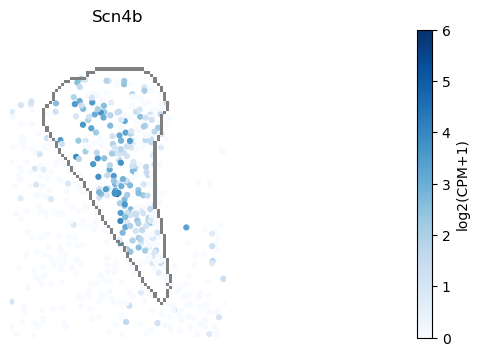

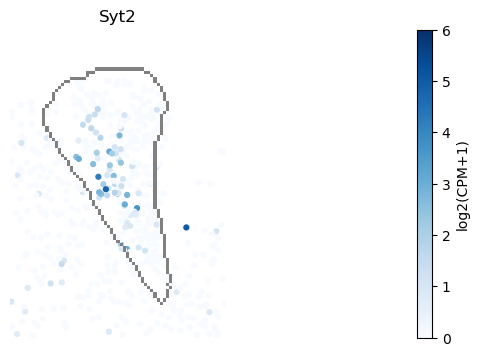

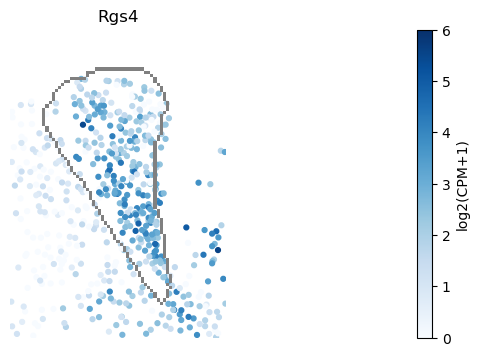

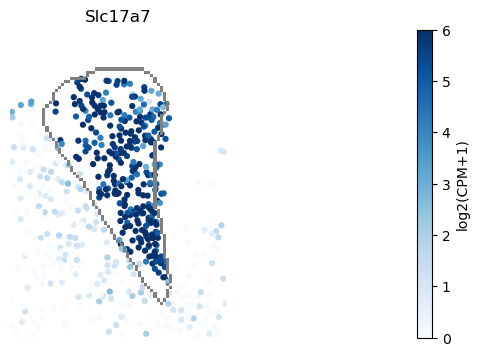

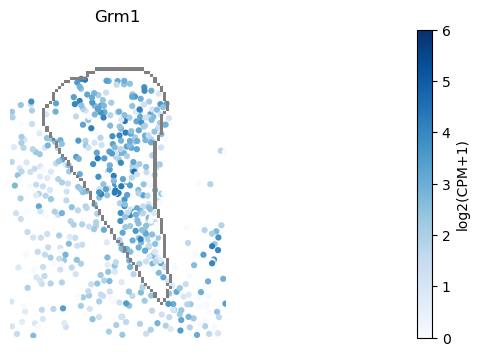

In [16]:
kwargs = dict(
              s=12
             )
section = [8.0]
cluster_id = '2614'
for gene in de_genes_AD_clust_neg[:5]:
    curr_fig = cplots.plot_expression_ccf(adata_th_zi_neurons, gene, ccf_polygons,
                                          sections=section, nuclei=highlight_nuclei, 
                                          highlight=highlight_nuclei,
                                           cmap='Blues', bg_shapes=False, show_outline=False,
                                           section_col=section_col, 
                                           x_col=x_col, y_col=y_col,
                                           custom_xy_lims=[4.4,5.1, 5.6,4.6],
                                           cb_vmin_vmax=[0,6], **kwargs)
    curr_fig[0].savefig('/root/capsule/results/'+f'abc_deg_AD_cluster{cluster_id}_{gene}.pdf', 
                bbox_inches='tight')

### AV - subclass vs rest

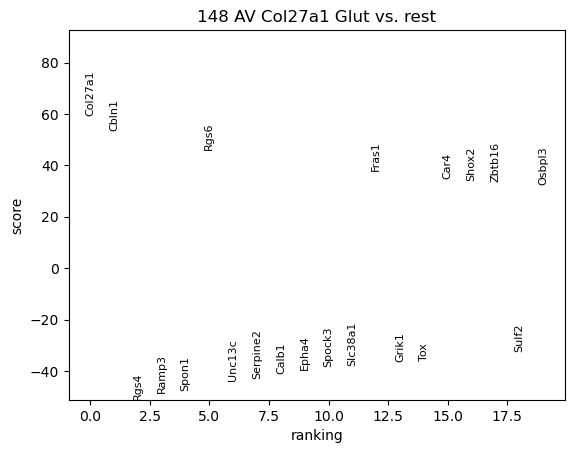

Top 10 pos DE genes for AV subclass:
 ['Col27a1', 'Cbln1', 'Rgs6', 'Fras1', 'Car4', 'Shox2', 'Zbtb16', 'Osbpl3', 'Npsr1', 'C1ql3']


In [17]:
# AV subclass - 148 AV Col27a1 Glut

# Plot top 20 DE genes
sc.tl.rank_genes_groups(adata_th_zi_neurons, 'subclass', 
                        groups=['148 AV Col27a1 Glut'], method='wilcoxon', 
                        rankby_abs=True)
sc.pl.rank_genes_groups(adata_th_zi_neurons, n_genes=20)

# List top 10 positive DE genes
de_df = sc.get.rank_genes_groups_df(adata_th_zi_neurons, group=None)
de_genes_pos_AV = de_df[de_df['scores']>0].head(10).names.to_list()
print('Top 10 pos DE genes for AV subclass:\n', de_genes_pos_AV)

#### Col27a1

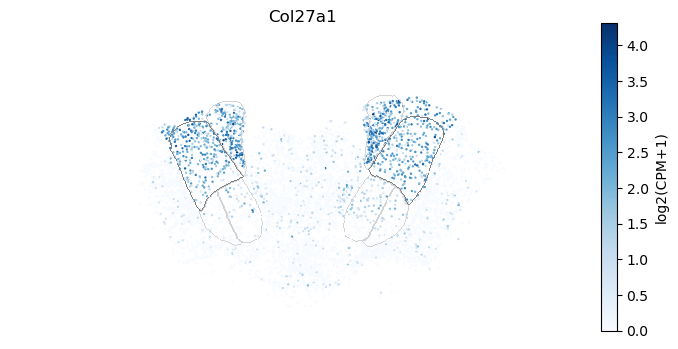

In [18]:
gene = 'Col27a1'

section=['C57BL6J-638850.44']
ant_nuclei=['AD', 'AV', 'AMd', 'AMv']
highlight_nuclei=['AV']

section_col = 'brain_section_label'
x_col = 'x_reconstructed'
y_col = 'y_reconstructed'

cplots.plot_expression_ccf(adata_th_zi_neurons, gene, ccf_polygons,
                           sections=section, nuclei=ant_nuclei, 
                           highlight=highlight_nuclei,
                           cmap='Blues', bg_shapes=False, show_outline=False,
                           section_col=section_col, 
                           x_col=x_col, y_col=y_col);

### AV - clusters

#### AV - 2615 vs 2616 clusters

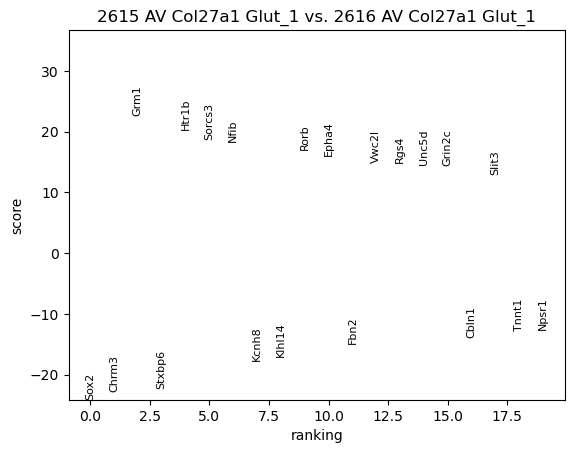

Top 10 DE genes:
 ['Sox2', 'Chrm3', 'Grm1', 'Stxbp6', 'Htr1b', 'Sorcs3', 'Nfib', 'Kcnh8', 'Klhl14', 'Rorb']

Top 10 pos DE genes:
 ['Grm1', 'Htr1b', 'Sorcs3', 'Nfib', 'Rorb', 'Epha4', 'Vwc2l', 'Rgs4', 'Unc5d', 'Grin2c']

 Top 10 neg DE genes:
 ['Sox2', 'Chrm3', 'Stxbp6', 'Kcnh8', 'Klhl14', 'Fbn2', 'Cbln1', 'Tnnt1', 'Npsr1', 'Chrm2']


In [19]:
taxonomy_level = 'cluster'
AV_cluster_labels = ['2615 AV Col27a1 Glut_1', '2616 AV Col27a1 Glut_1']

sc.tl.rank_genes_groups(adata_th_zi_neurons, taxonomy_level, 
                        groups=[AV_cluster_labels[0]], 
                        reference=AV_cluster_labels[1], 
                        method='wilcoxon', rankby_abs=True)
sc.pl.rank_genes_groups(adata_th_zi_neurons, n_genes=20)

de_df = sc.get.rank_genes_groups_df(adata_th_zi_neurons, group=None)
de_genes_AV_clust_all = de_df.head(10).names.to_list()
de_genes_AV_clust_pos = de_df[de_df['scores']>0].head(10).names.to_list()
de_genes_AV_clust_neg = de_df[de_df['scores']<0].head(10).names.to_list()
print('Top 10 DE genes:\n', de_genes_AV_clust_all)
print('\nTop 10 pos DE genes:\n', de_genes_AV_clust_pos)
print('\n','Top 10 neg DE genes:\n', de_genes_AV_clust_neg)

##### 2615 (medial cluster) DE genes

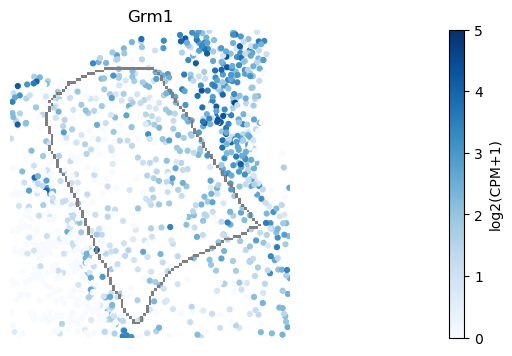

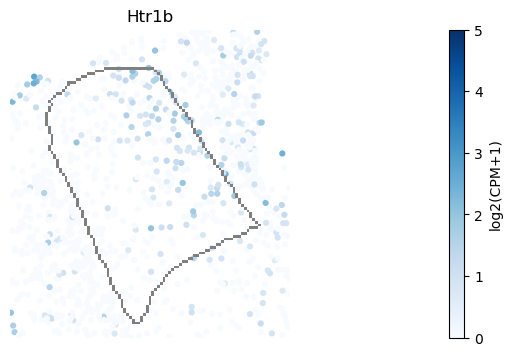

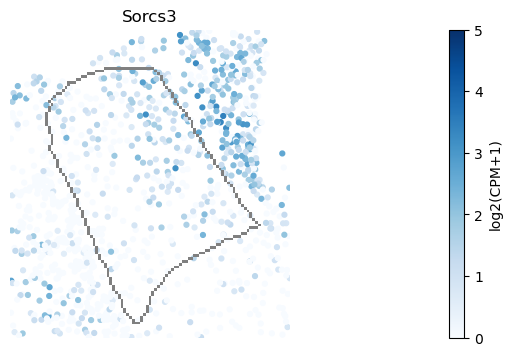

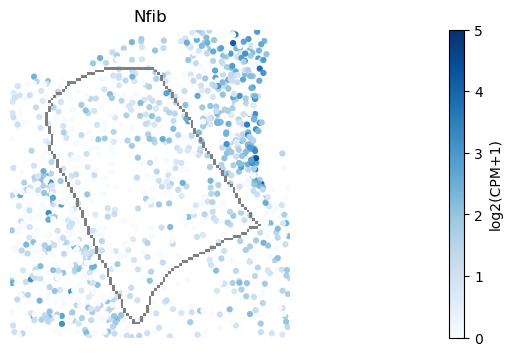

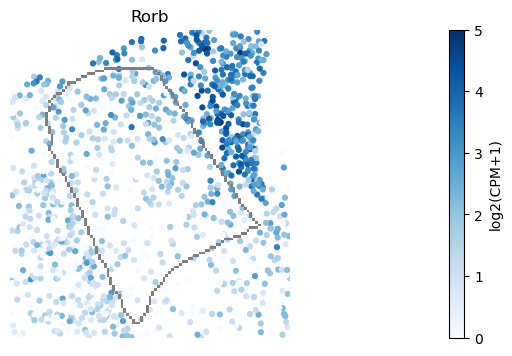

In [20]:
section=[8.0]
ant_nuclei=['AD', 'AV', 'AMd', 'AMv']
highlight_nuclei=['AV']

section_col = 'z_reconstructed'
x_col = 'x_reconstructed'
y_col = 'y_reconstructed'

kwargs = dict(
              s=12
             )
cluster_id = '2615'
for gene in de_genes_AV_clust_pos[:5]:
    curr_fig = cplots.plot_expression_ccf(adata_th_zi_neurons, gene, ccf_polygons,
                                          sections=section, nuclei=highlight_nuclei, 
                                          highlight=highlight_nuclei,
                                           cmap='Blues', bg_shapes=False, show_outline=False,
                                           section_col=section_col, 
                                           x_col=x_col, y_col=y_col,
                                           custom_xy_lims=[4.0,5.0, 5.9,4.8],
                                           cb_vmin_vmax=[0,5],
                                          **kwargs)
    curr_fig[0].savefig('/root/capsule/results/'+f'abc_deg_AV_cluster{cluster_id}_{gene}.pdf', 
                bbox_inches='tight')

##### 2616 (lateral cluster) DE genes

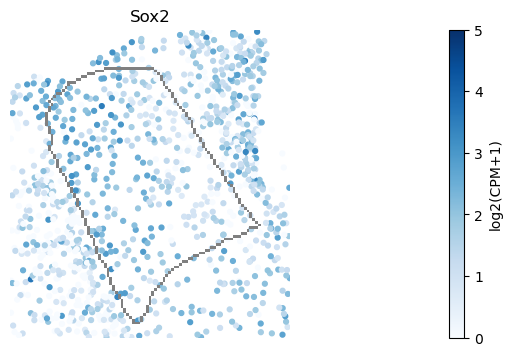

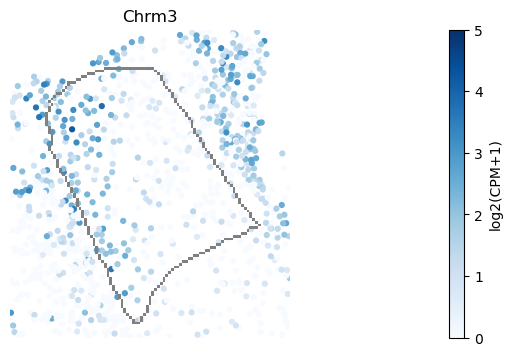

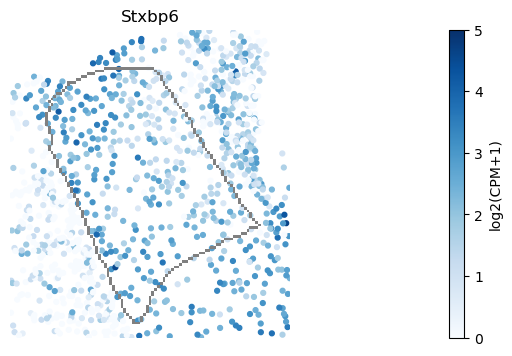

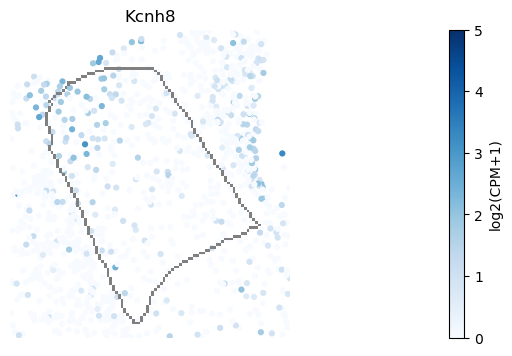

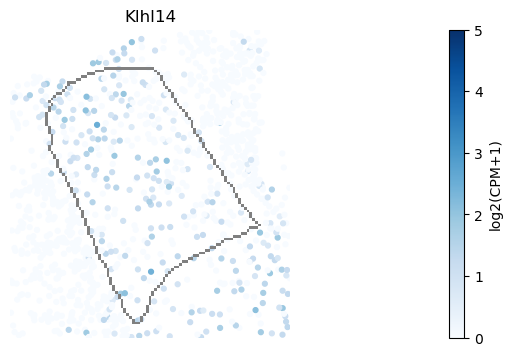

In [21]:
section=[8.0]
ant_nuclei=['AD', 'AV', 'AMd', 'AMv']
highlight_nuclei=['AV']

section_col = 'z_reconstructed'
x_col = 'x_reconstructed'
y_col = 'y_reconstructed'

kwargs = dict(
              s=12
             )
cluster_id = '2616'
for gene in de_genes_AV_clust_neg[:5]:
    curr_fig = cplots.plot_expression_ccf(adata_th_zi_neurons, gene, ccf_polygons,
                                          sections=section, nuclei=highlight_nuclei, 
                                          highlight=highlight_nuclei,
                                           cmap='Blues', bg_shapes=False, show_outline=False,
                                           section_col=section_col, 
                                           x_col=x_col, y_col=y_col,
                                           custom_xy_lims=[4.0,5.0, 5.9,4.8],
                                           cb_vmin_vmax=[0,5],
                                          **kwargs)
    curr_fig[0].savefig('/root/capsule/results/'+f'abc_deg_AV_cluster{cluster_id}_{gene}.pdf', 
                bbox_inches='tight')

#### Sorcs3

Mathew's plots in brain1 suggested high expression exclusively in the '1097 AV Col27a1 Glut cluster' in the AV

That does not appear to be the case in brain3...

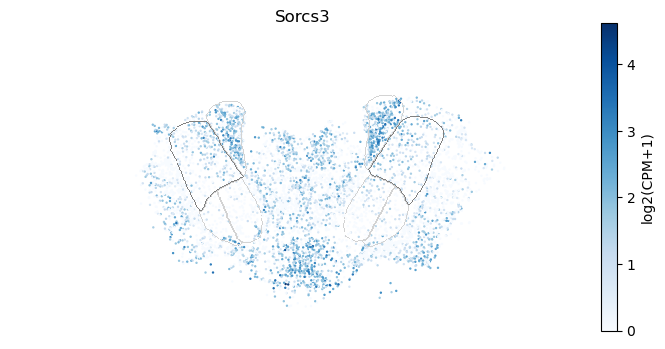

In [22]:
# Mathew's plots in brain1 suggested high expression exclusively in the '1097 AV Col27a1 Glut cluster' in the AV
# That does not appear to be the case in brain3...
gene = 'Sorcs3'

section=['C57BL6J-638850.44']
ant_nuclei=['AD', 'AV', 'AMd', 'AMv']
highlight_nuclei=['AV']

section_col = 'brain_section_label'
x_col = 'x_reconstructed'
y_col = 'y_reconstructed'

cplots.plot_expression_ccf(adata_th_zi_neurons, gene, ccf_polygons,
                           sections=section, nuclei=ant_nuclei, 
                           highlight=highlight_nuclei,
                           cmap='Blues', bg_shapes=False, show_outline=False,
                           section_col=section_col, 
                           x_col=x_col, y_col=y_col);

### AM - supertype vs rest

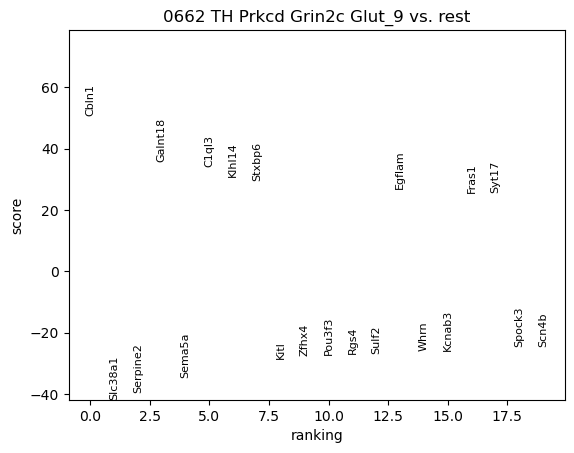

Top 10 pos DE genes for AM supertype:
 ['Cbln1', 'Galnt18', 'C1ql3', 'Klhl14', 'Stxbp6', 'Egflam', 'Fras1', 'Syt17', 'Rgs6', 'Nr2f1']


In [23]:
# AV supertype - 0662 TH Prkcd Grin2c Glut_9

# Plot top 20 DE genes
sc.tl.rank_genes_groups(adata_th_zi_neurons, 'supertype', 
                        groups=['0662 TH Prkcd Grin2c Glut_9'],  
                        method='wilcoxon', rankby_abs=True)
sc.pl.rank_genes_groups(adata_th_zi_neurons, n_genes=20)

# List top 10 positive DE genes
de_df = sc.get.rank_genes_groups_df(adata_th_zi_neurons, group=None)
de_genes_pos_AM = de_df[de_df['scores']>0].head(10).names.to_list()
print('Top 10 pos DE genes for AM supertype:\n', de_genes_pos_AM)

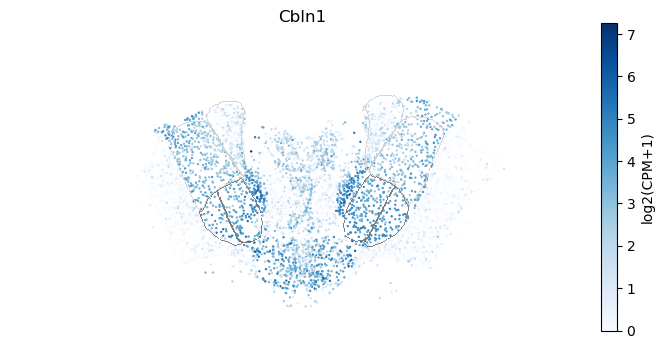

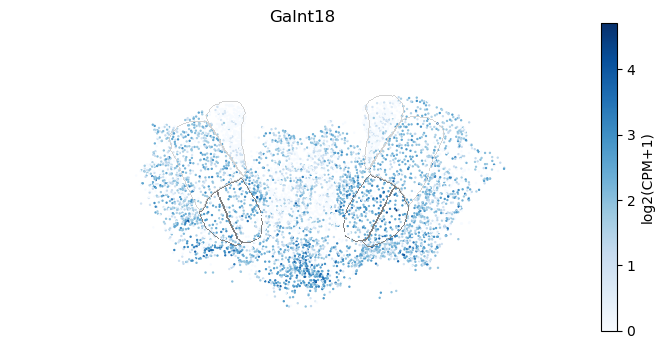

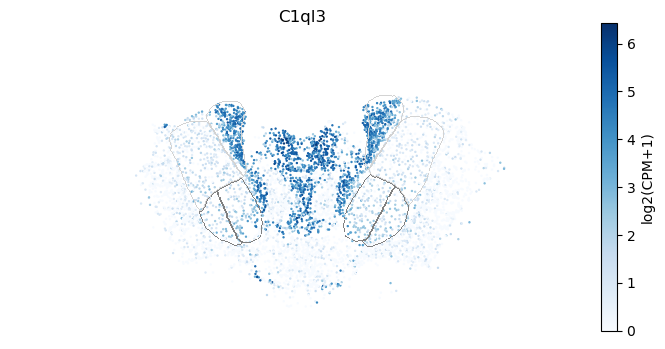

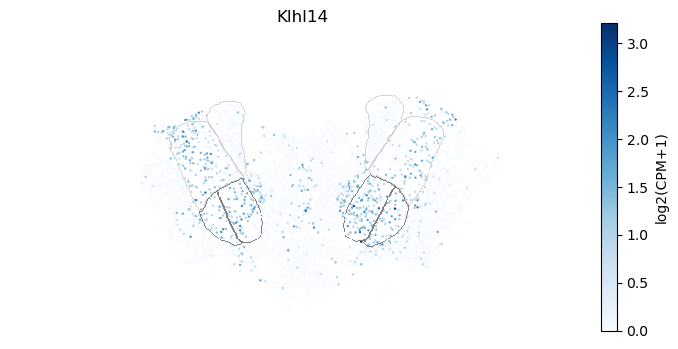

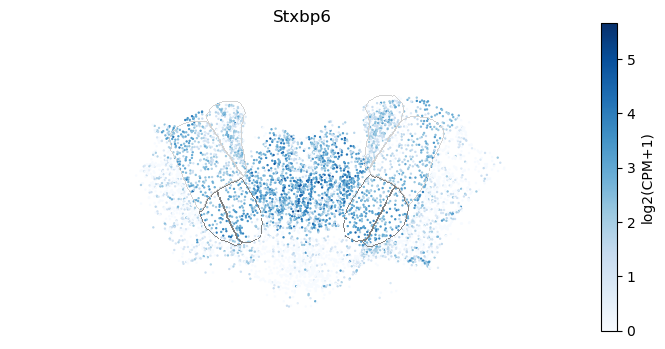

In [24]:
section=['C57BL6J-638850.44']
ant_nuclei=['AD', 'AV', 'AMd', 'AMv']
highlight_nuclei=['AMv','AMd']

section_col = 'brain_section_label'
x_col = 'x_reconstructed'
y_col = 'y_reconstructed'

for gene in de_genes_pos_AM[:5]:
    cplots.plot_expression_ccf(adata_th_zi_neurons, gene, ccf_polygons,
                               sections=section, nuclei=ant_nuclei, 
                               highlight=highlight_nuclei,
                               cmap='Blues', bg_shapes=False, show_outline=False,
                               section_col=section_col, 
                               x_col=x_col, y_col=y_col);

### AM clusters

In [25]:
AM_cluster_labels = ['2674 TH Prkcd Grin2c Glut_9',
                     '2675 TH Prkcd Grin2c Glut_9',
                     '2676 TH Prkcd Grin2c Glut_9']

#### 2674 (AMd?) vs 2675 (AMv?)

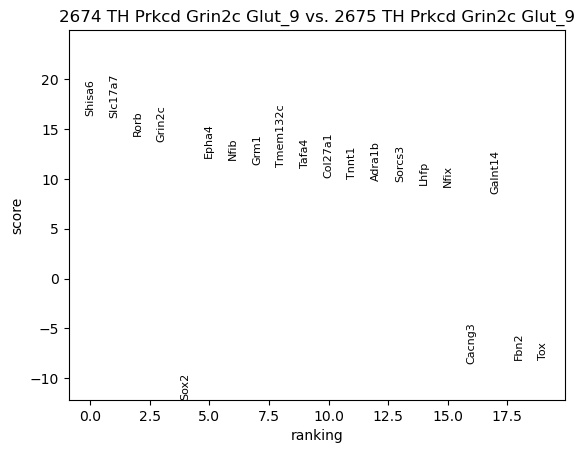

Top 10 DE genes:
 ['Shisa6', 'Slc17a7', 'Rorb', 'Grin2c', 'Sox2', 'Epha4', 'Nfib', 'Grm1', 'Tmem132c', 'Tafa4']

Top 10 pos DE genes:
 ['Shisa6', 'Slc17a7', 'Rorb', 'Grin2c', 'Epha4', 'Nfib', 'Grm1', 'Tmem132c', 'Tafa4', 'Col27a1']

 Top 10 neg DE genes:
 ['Sox2', 'Cacng3', 'Fbn2', 'Tox', 'Stxbp6', 'Fli1', 'Tmie', 'Drd1', 'Gad2', 'Adcy2']


In [26]:
taxonomy_level = 'cluster'
sc.tl.rank_genes_groups(adata_th_zi_neurons, taxonomy_level, 
                        groups=[AM_cluster_labels[0]], 
                        reference=AM_cluster_labels[1], 
                        method='wilcoxon', rankby_abs=True)
sc.pl.rank_genes_groups(adata_th_zi_neurons, n_genes=20)

# List top 10 positive DE genes
de_df = sc.get.rank_genes_groups_df(adata_th_zi_neurons, group=None)
de_genes_AM_clust_all = de_df.head(10).names.to_list()
de_genes_AM_clust_pos = de_df[de_df['scores']>0].head(10).names.to_list()
de_genes_AM_clust_neg = de_df[de_df['scores']<0].head(10).names.to_list()
print('Top 10 DE genes:\n', de_genes_AM_clust_all)
print('\nTop 10 pos DE genes:\n', de_genes_AM_clust_pos)
print('\n','Top 10 neg DE genes:\n', de_genes_AM_clust_neg)

##### AMd markers? (2674 vs 2675 pos. DEG)

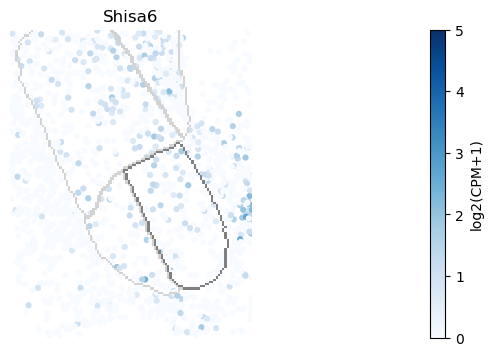

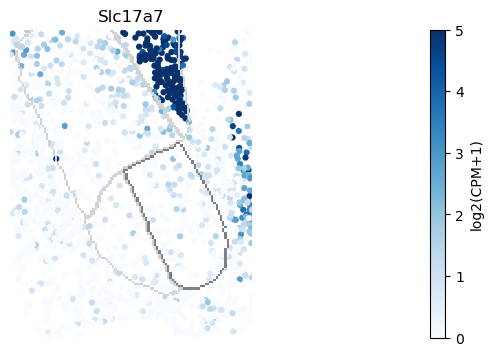

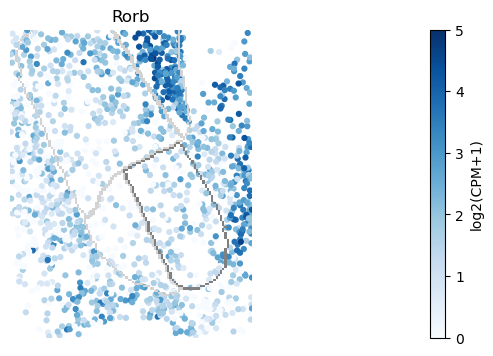

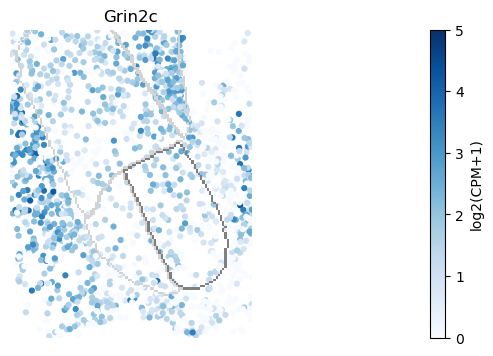

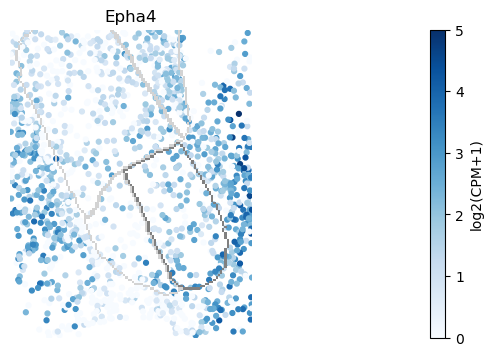

In [27]:
section=[8.0]
ant_nuclei=['AD', 'AV', 'AMd', 'AMv']
highlight_nuclei=['AMd']

section_col = 'z_reconstructed'
x_col = 'x_reconstructed'
y_col = 'y_reconstructed'

kwargs = dict(
              s=12
             )
cluster_id = '2674'
for gene in de_genes_AM_clust_pos[:5]:
    curr_fig = cplots.plot_expression_ccf(adata_th_zi_neurons, gene, ccf_polygons,
                                          sections=section, nuclei=ant_nuclei, 
                                          highlight=highlight_nuclei,
                                           cmap='Blues', bg_shapes=False, show_outline=False,
                                           section_col=section_col, 
                                           x_col=x_col, y_col=y_col,
                                           custom_xy_lims=[4.1,5.2, 6.4,5.0],
                                           cb_vmin_vmax=[0,5],
                                          **kwargs)
    curr_fig[0].savefig('/root/capsule/results/'+f'abc_deg_AMd_cluster{cluster_id}_{gene}.pdf', 
                        bbox_inches='tight')

##### AMv markers? (2674 vs 2675 neg. DEG)

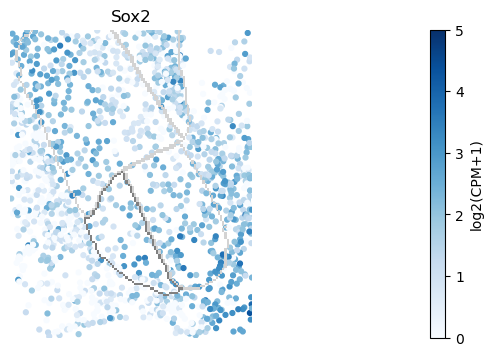

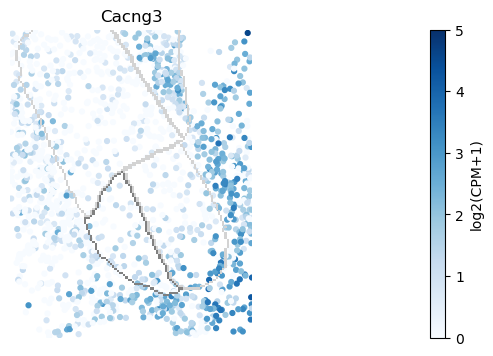

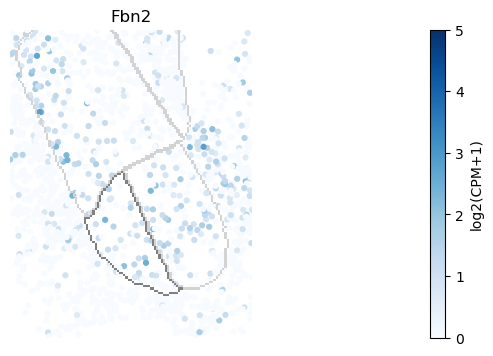

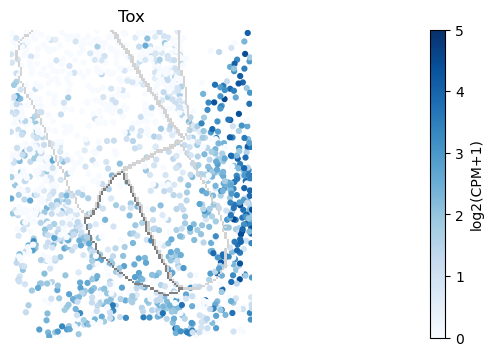

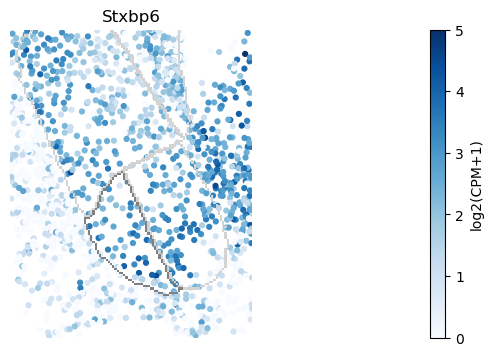

In [28]:
section=[8.0]
ant_nuclei=['AD', 'AV', 'AMd', 'AMv']
highlight_nuclei=['AMv']

section_col = 'z_reconstructed'
x_col = 'x_reconstructed'
y_col = 'y_reconstructed'

kwargs = dict(
              s=12
             )
cluster_id = '2676'
for gene in de_genes_AM_clust_neg[:5]:
    curr_fig = cplots.plot_expression_ccf(adata_th_zi_neurons, gene, ccf_polygons,
                                          sections=section, nuclei=ant_nuclei, 
                                          highlight=highlight_nuclei,
                                           cmap='Blues', bg_shapes=False, show_outline=False,
                                           section_col=section_col, 
                                           x_col=x_col, y_col=y_col,
                                           custom_xy_lims=[4.1,5.2, 6.4,5.0],
                                           cb_vmin_vmax=[0,5],
                                          **kwargs)
    curr_fig[0].savefig('/root/capsule/results/'+f'abc_deg_AMv_cluster{cluster_id}_{gene}.pdf', 
                        bbox_inches='tight')

### ANT vs rest

In [29]:
# left as an exercise to the reader...

# obs_th_neurons['anterior_type'] = (obs_th_neurons['supertype'].str.contains('Glut_9') |
#                                        obs_th_neurons['supertype'].str.contains('AD') |
#                                        obs_th_neurons['supertype'].str.contains('AV')).astype(str)